In [1]:
# append current path by path to the project
import sys
sys.path.append('../')

import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.data_handling import load_dataset
from src.config import STRATEGY as strategy
from src.config import (BATCH_SIZE, IMAGE_SIZE, BATCH_SIZE, SIZE_RESIZE, AUTOTUNE, EPOCHS)

import warnings
warnings.filterwarnings("ignore")

Number of replicas: 1
Number of replicas: 1


/Users/szczekulskij/.pyenv/versions/3.8.16/envs/monet-me-this/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Data

In [2]:
MONET_FILENAMES = tf.io.gfile.glob("../images/artists/monet/monet_tfrec/*.tfrec")
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob("../images/random_images/photo_tfrec/*.tfrec")
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

monet_ds = load_dataset(MONET_FILENAMES, apply_jitter=False)
photo_ds = load_dataset(PHOTO_FILENAMES, apply_jitter=False)

photo_ds_test = load_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)

2024-01-16 17:48:39.858437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 17:48:39.858457: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Monet TFRecord Files: 5
Photo TFRecord Files: 20
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-01-16 17:48:39.973674: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-16 17:48:40.063701: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-01-16 17:48:40.180929: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


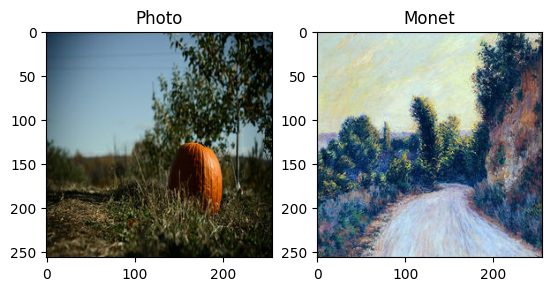

In [3]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [4]:
monet_generator = tf.keras.models.load_model('saved_models/monet_generator.h5')


In [5]:
# transform all images to monet style based on PHOTO_FILENAMES and save them to the folder
SIZE_RESIZE = 1024

def normalize(img):
    img_ = np.array(img)
    assert img_.shape[2] == 3
    maxi = img_.max()
    mini = img_.min()
    return (img_ - mini)/(maxi-mini)

i = 0
for img in photo_ds:
    transformed = monet_generator(img, training=False)[0].numpy()
    transformed = tf.image.resize(transformed, (SIZE_RESIZE, SIZE_RESIZE))
    # transformed = (transformed * 127.5 + 127.5)
    transformed = normalize(transformed)
    # transformed = transformed.numpy()  # Convert the tensor to a numpy array
    # # transformed = transformed.astype(np.uint8)  # Cast the numpy array to uint8
    plt.imsave(f'../images/artists/monet/monet_generated/{i}.jpg', transformed)
    i += 1